In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

artist_all      artist_base  rank  \
3381                   digable planets  digable planets    81   
5056  ludacris  featuring  nicki minaj         ludacris    56   
537                      barbara lewis    barbara lewis    38   

                                  song  year artist_featured  \
3381  rebirth of slick (cool like dat)  1993             NaN   
5056                      my chick bad  2010     nicki minaj   
537                     baby i'm yours  1965             NaN   

                          song_clean     artist_clean  \
3381  rebirth of slick cool like dat  digable planets   
5056                    my chick bad         ludacris   
537                    baby im yours    barbara lewis   

                                                 lyrics  danceability  ...  \
3381   we like the breeze flow straight out of our l...         0.884  ...   
5056   my chick bad my chick hood my chick do stuff ...         0.687  ...   
537   baby im yours and ill be yours until the stars...         0.439  ...   

       tempo  time_signature  popularity  explicit  duration_min  num_words  \
3381  98.315             4.0        62.0     False       4.35445      599.0   
5056  84.897             4.0        36.0     False       3.61445      664.0   
537   98.996             4.0        38.0     False       2.50615      144.0   

      words_per_sec  num_uniq_words  decade  uniq_ratio  
3381       2.292674           275.0    1990    0.459098  
5056       3.061784           193.0    2010    0.290663  
537        0.957644            66.0    1960    0.458333  

[3 rows x 29 columns]

## 1-grams 

In [3]:
# generate distributed representations of tokens that appear more than twice
min_count = 2 # a word has to appear at least twice in order to be taken seriously
lyrics = df['lyrics'].dropna().values.tolist() # each song is an element in this list 
lyrics_tokenized = [lyric.split() for lyric in lyrics] # lyrics_tokenized is a list of lists
model = Word2Vec(sentences=lyrics_tokenized, vector_size=50, min_count=min_count, window=5)
word_embeddings = model.wv

In [4]:
# when creating word clouds, maps word fontsize to a color
from random import Random


class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

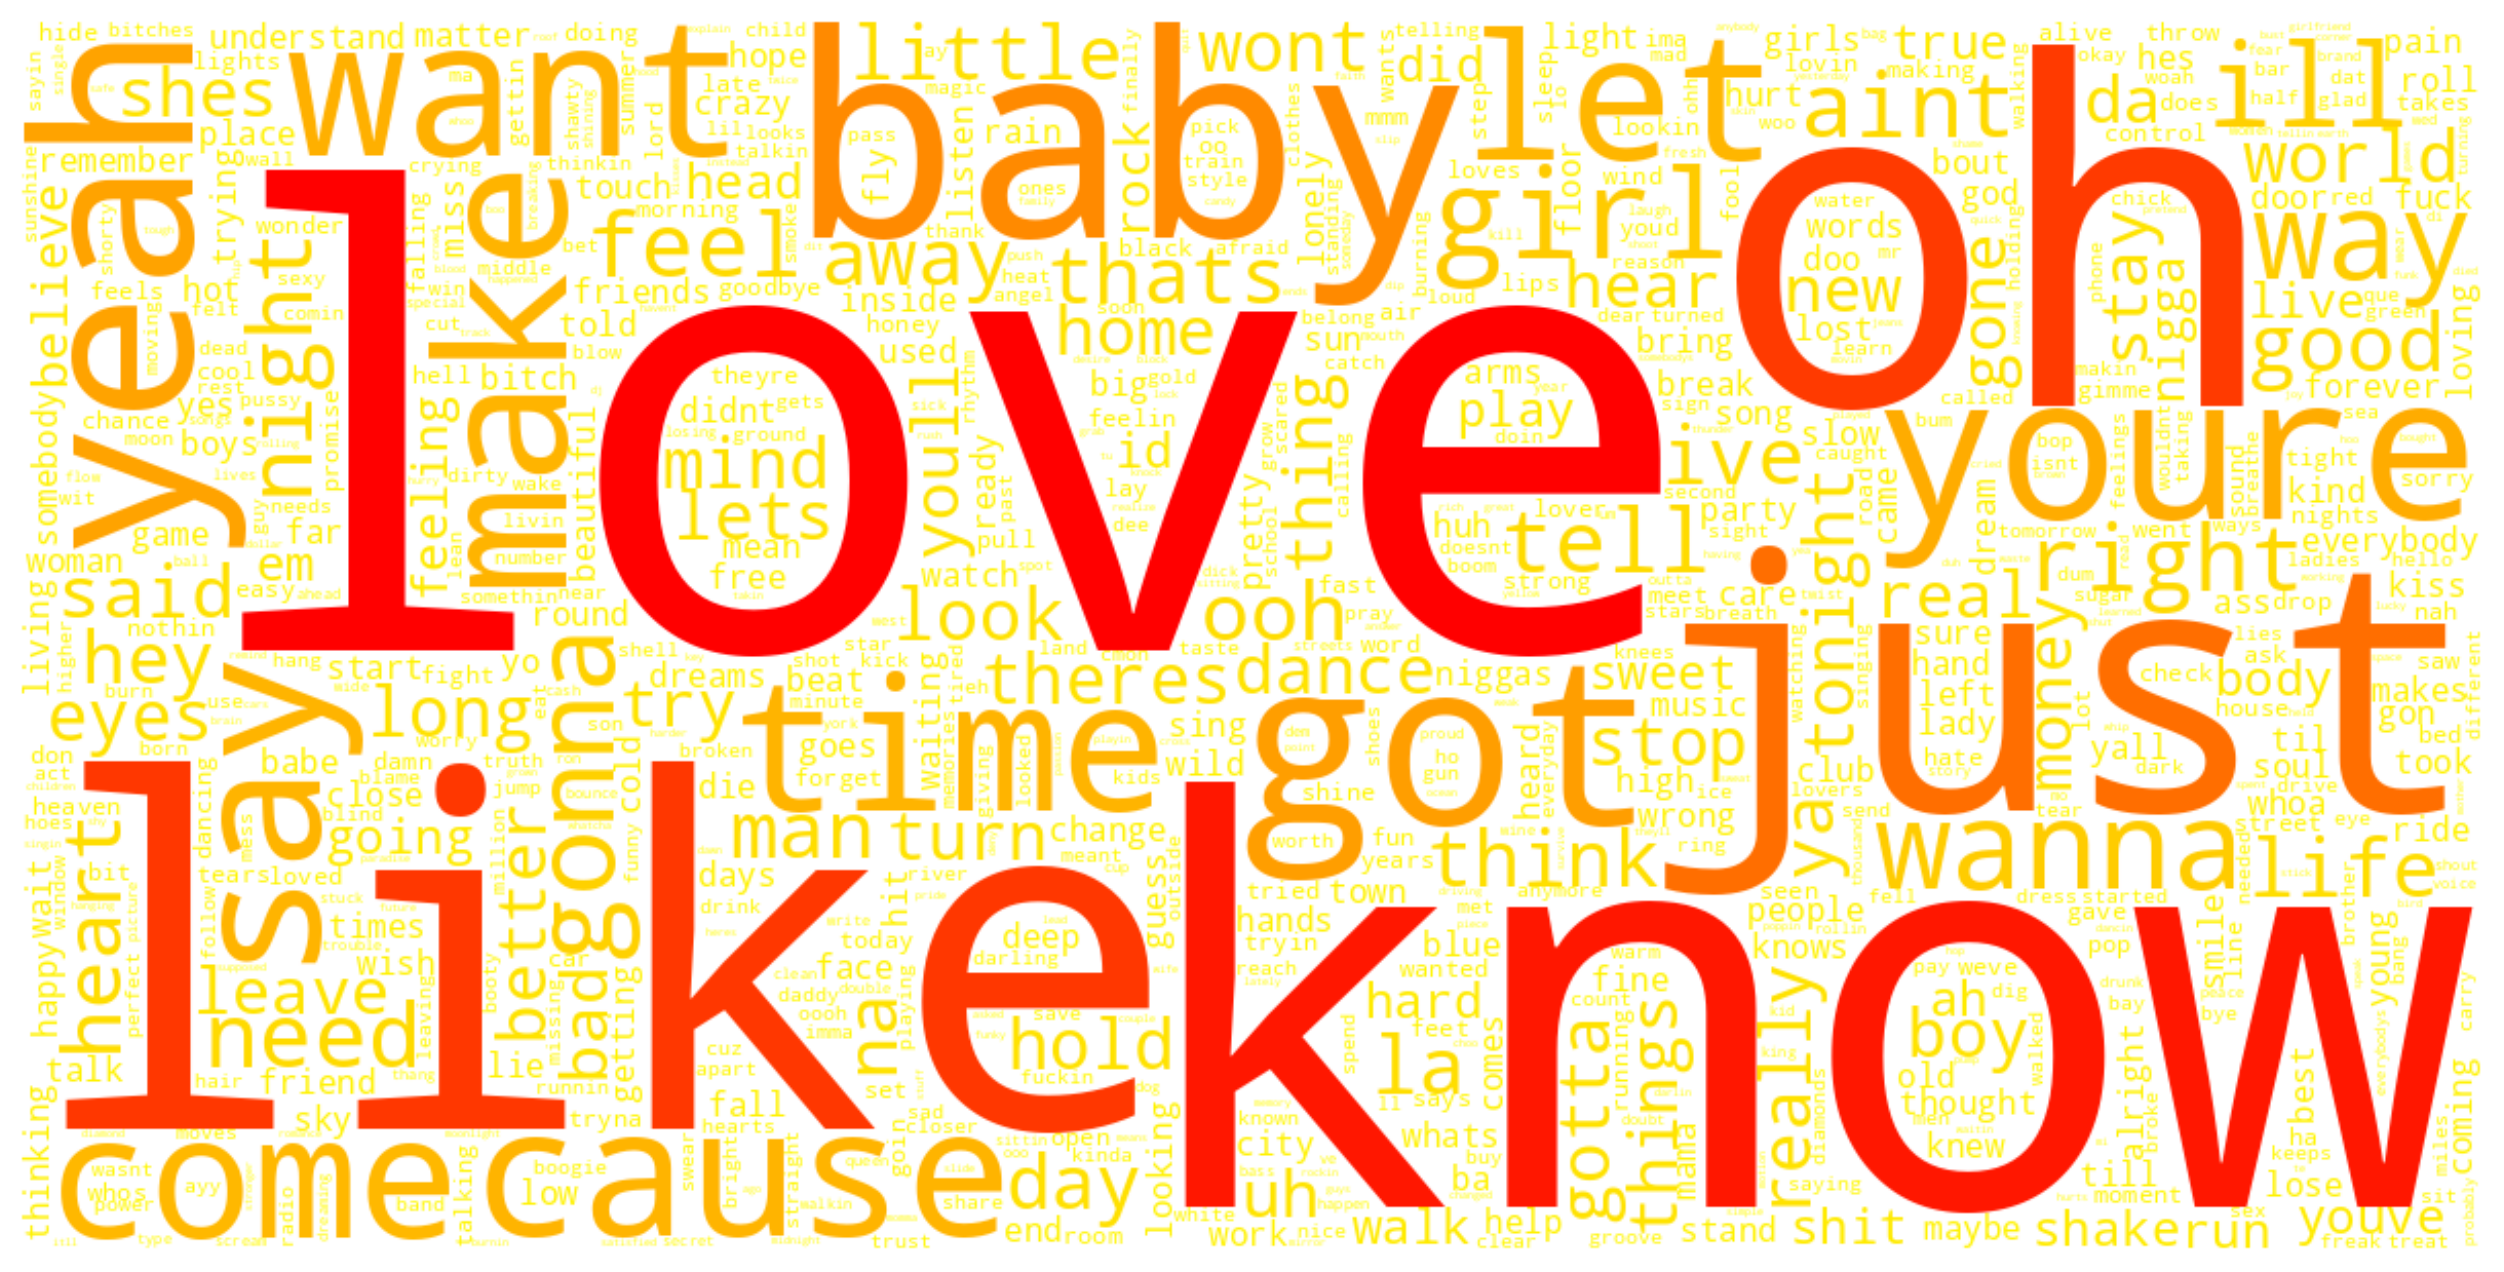

In [5]:
# calculate word frequencies
stop_words = list(ENGLISH_STOP_WORDS) + ['im', 'dont']
count_vectorizer = CountVectorizer(stop_words=stop_words)
count_vectorizer.fit(np.array(lyrics))
freqs = np.array(count_vectorizer.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count_vectorizer.get_feature_names_out(), freqs))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('autumn_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');

## bigrams

In [6]:
count_bigrams = CountVectorizer(stop_words='english', ngram_range=(2,2))
count_bigrams.fit(lyrics)

CountVectorizer(ngram_range=(2, 2), stop_words='english')

In [7]:
# calculate bigram frequencies 
freq_bigrams = count_bigrams.transform(np.array(lyrics)).sum(axis=0)
print(type(freq_bigrams))
print(freq_bigrams.shape)
freq_bigrams = np.array(freq_bigrams).squeeze() # squeeze() only works with numpy arrays, not matrix
print(freq_bigrams.shape)

<class 'numpy.matrix'>
(1, 304247)
(304247,)


In [8]:
count_bigrams.get_feature_names_out()[-1]

'站在中间 有谁站在中间'

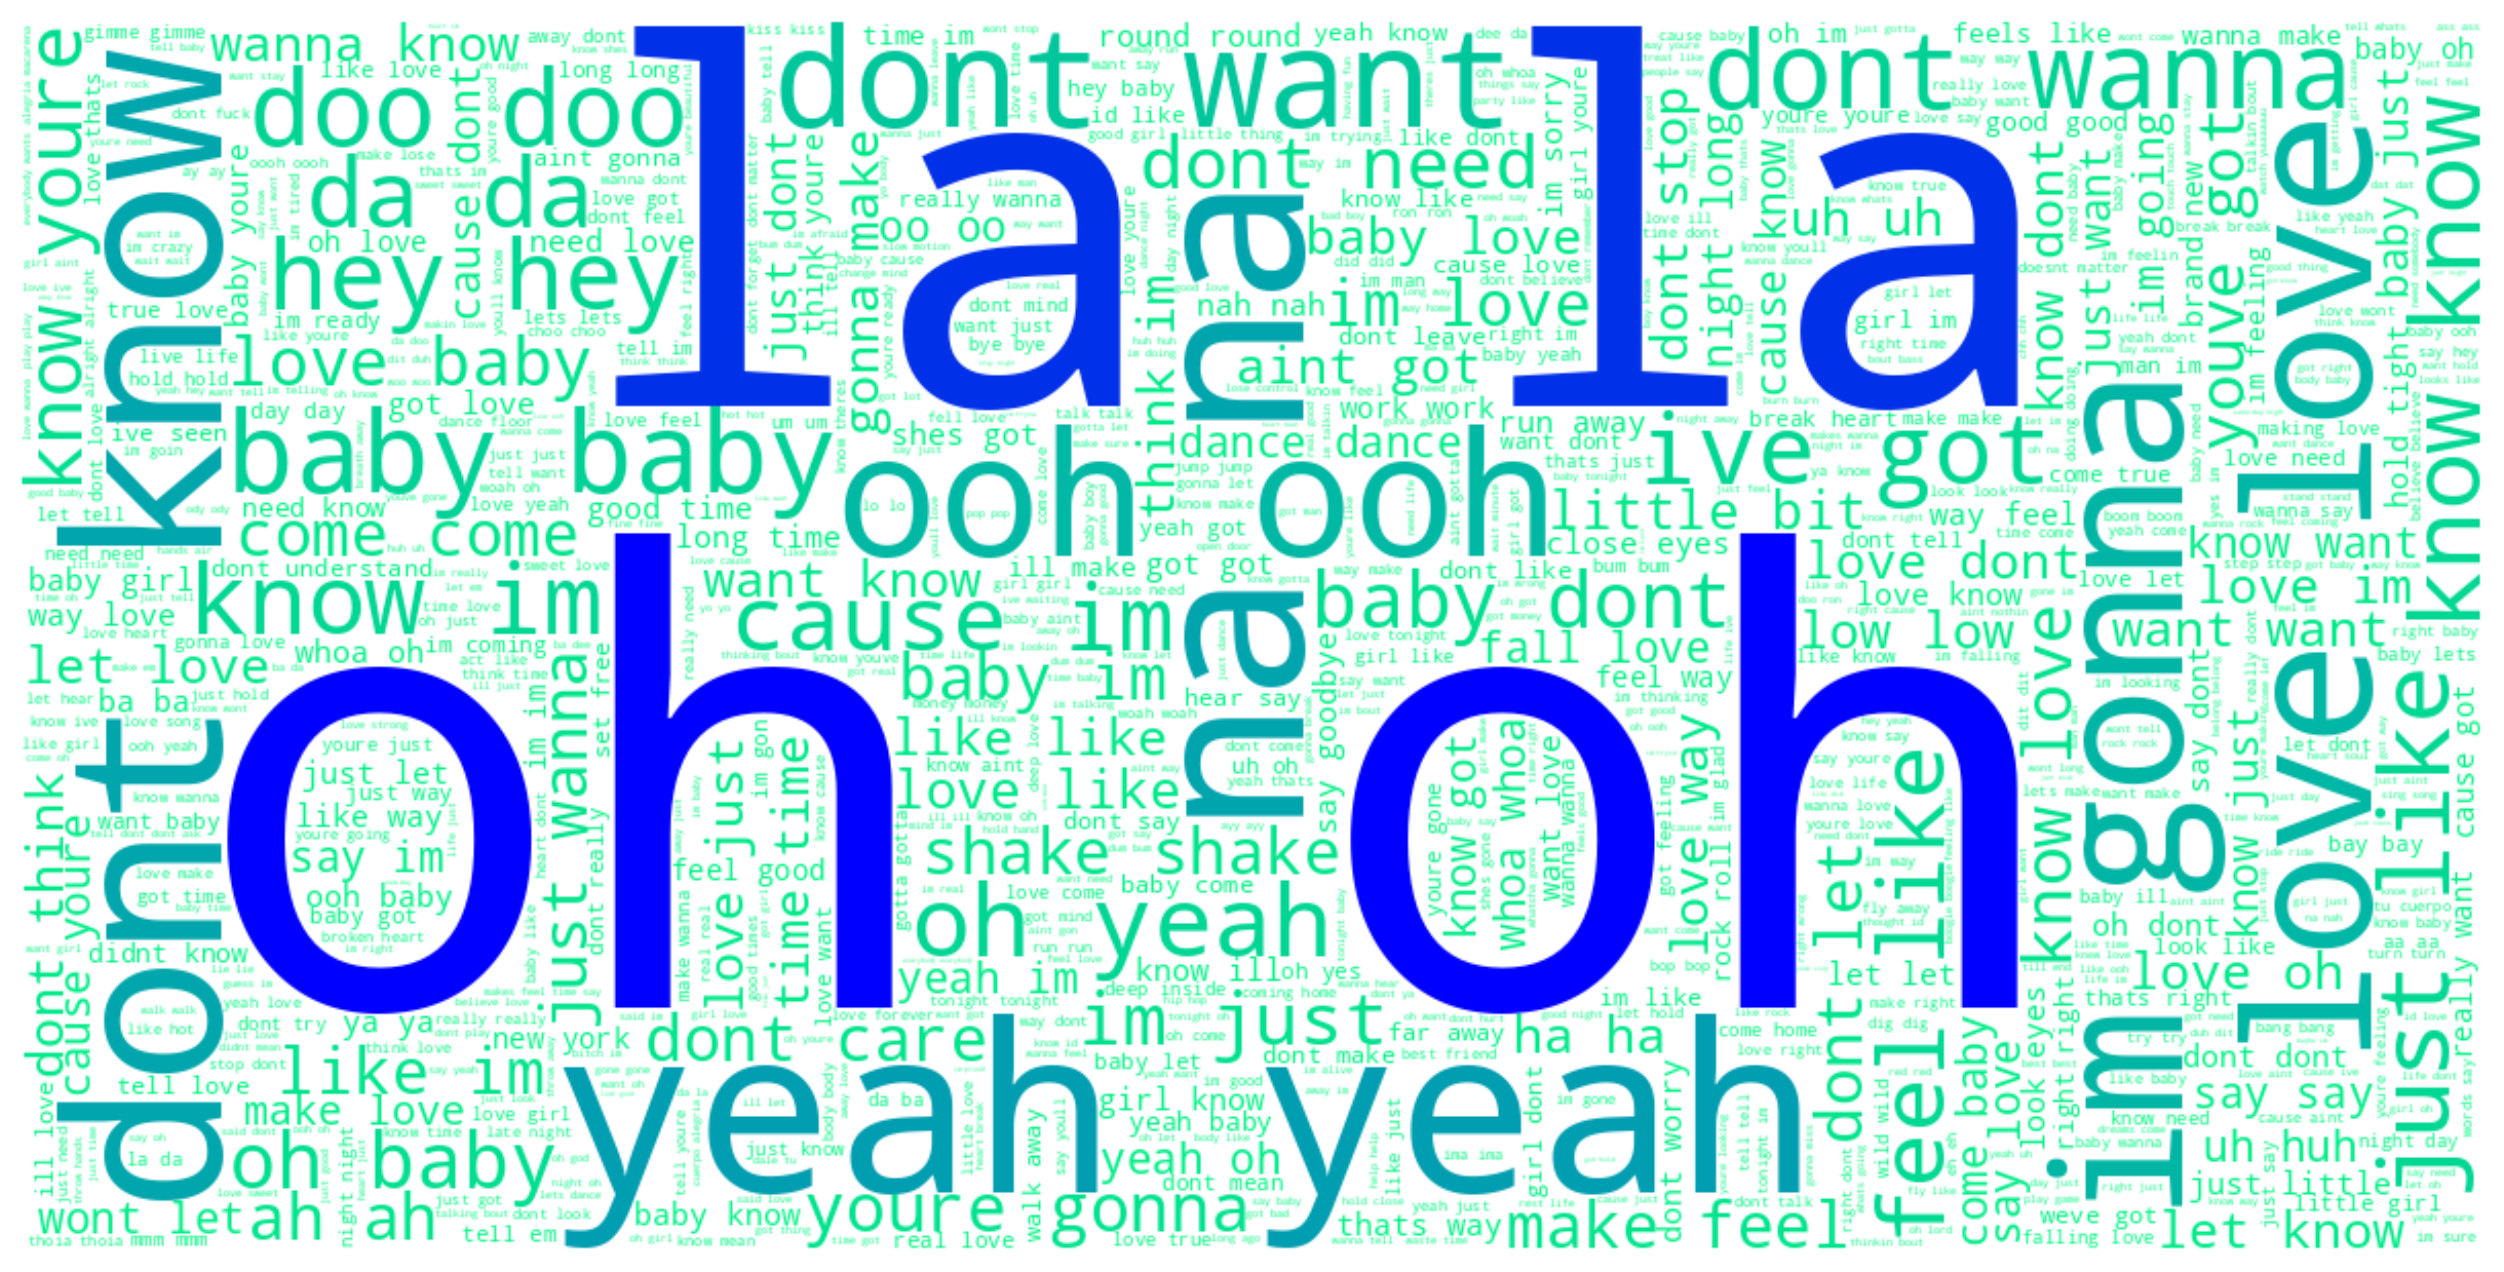

In [9]:
# make word cloud
word_freq_dict = dict(zip(count_bigrams.get_feature_names_out(), freq_bigrams))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('winter_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');